In [93]:
!pip install hmmlearn

In [94]:
#!pip install --quiet --user git+https://github.com/hmmlearn/hmmlearn
from hmmlearn import hmm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense,BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate,LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from scipy.stats import kurtosis
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [95]:
#load Data


df = pd.read_csv('/content/stapler-ds (1).csv',parse_dates=True)
df

,Unnamed: 0,id,TimeMS,Avg_Velocity,PWM_Output,SG_NoFilter,Setpoint,StrainGage,avg_current,current_filter,ticks,True_Endstop_Time_ms,Articulation,Tissue,Tissue_Thickness_inch,Firing_Type
0,0,100,0,0.00,153,11,33750,1,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
1,1,100,1,0.00,165,11,33750,2,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
2,2,100,2,0.00,176,11,33750,4,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
3,3,100,3,0.00,188,11,33750,5,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
4,4,100,4,0.00,199,11,33750,6,0,0,0,3360,Full Push,Bowel,0.025,Un-interrupted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183005,3183005,97,4642,93.75,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted
3183006,3183006,97,4643,62.50,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted
3183007,3183007,97,4643,62.50,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted
3183008,3183008,97,4644,31.25,0,130,33750,128,0,0,-30682,4363,Full Push,Bowel,0.070,Un-interrupted


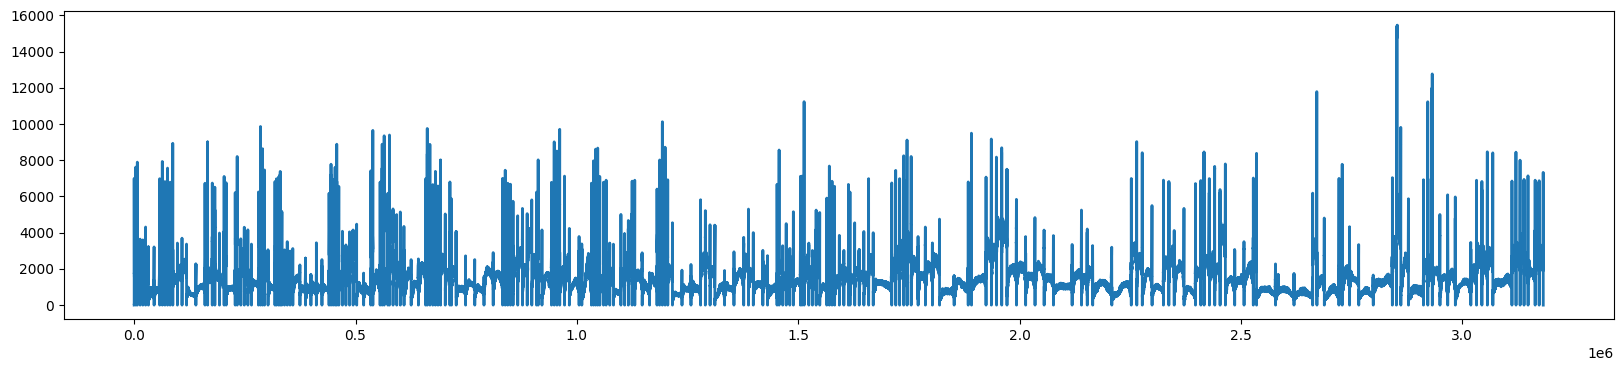

In [96]:
df.index.freq = 'TimeMS'
df.shape
df.columns
plt.figure(figsize=(20, 4))
plt.plot(df.avg_current, linewidth=2)
plt.show()

In [97]:
cols = ['id', 'TimeMS', 'Avg_Velocity', 'PWM_Output', 'SG_NoFilter', 'Setpoint', 'StrainGage', 'avg_current', 'current_filter', 'ticks', 'True_Endstop_Time_ms', 'Articulation', 'Tissue', 'Tissue_Thickness_inch', 'Firing_Type']
df = df[cols].rename({'True_Endstop_Time_ms':'Anomaly_At_Time_ms'}, axis=1)

measures = ['Avg_Velocity', 'StrainGage', 'avg_current', 'PWM_Output', 'Anomaly_At_Time_ms', 'id', 'TimeMS']

for i in range(1,6):
  measure=measures[i-1]
  print(measure.title())
df=df[measures]

Avg_Velocity
Straingage
Avg_Current
Pwm_Output
Anomaly_At_Time_Ms


In [98]:
df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,id,TimeMS
0,0.00,1,0,153,3360,100,0
1,0.00,2,0,165,3360,100,1
2,0.00,4,0,176,3360,100,2
3,0.00,5,0,188,3360,100,3
4,0.00,6,0,199,3360,100,4
...,...,...,...,...,...,...,...
3183005,93.75,128,0,0,4363,97,4642
3183006,62.50,128,0,0,4363,97,4643
3183007,62.50,128,0,0,4363,97,4643
3183008,31.25,128,0,0,4363,97,4644


In [99]:
def plot_measure(df):
  e=np.unique(df['Anomaly_At_Time_ms'])[0]
  df=df[df.TimeMS > 400]
  #plt.plot('TimeMS','StrainGage',data=df)
  #plt.plot('TimeMS','Avg_Velocity',data=df)
  plt.figure(figsize=(16,12))
  for i in range(1,5):
    measure=measures[i-1]
    plt.subplot(2,2,i)
    plt.title(measure.title() + ' from a surgical instrument')
    # naming the x axis
    plt.xlabel('Time in Milliseconds')
    # naming the y axis
    plt.ylabel(measure.title())
    plt.plot('TimeMS',measure,data=df)
    #plt.plot('TimeMS','avg_current',data=df)
    plt.legend(loc="upper left")
    plt.axvline(e, color='r')
  plt.show()

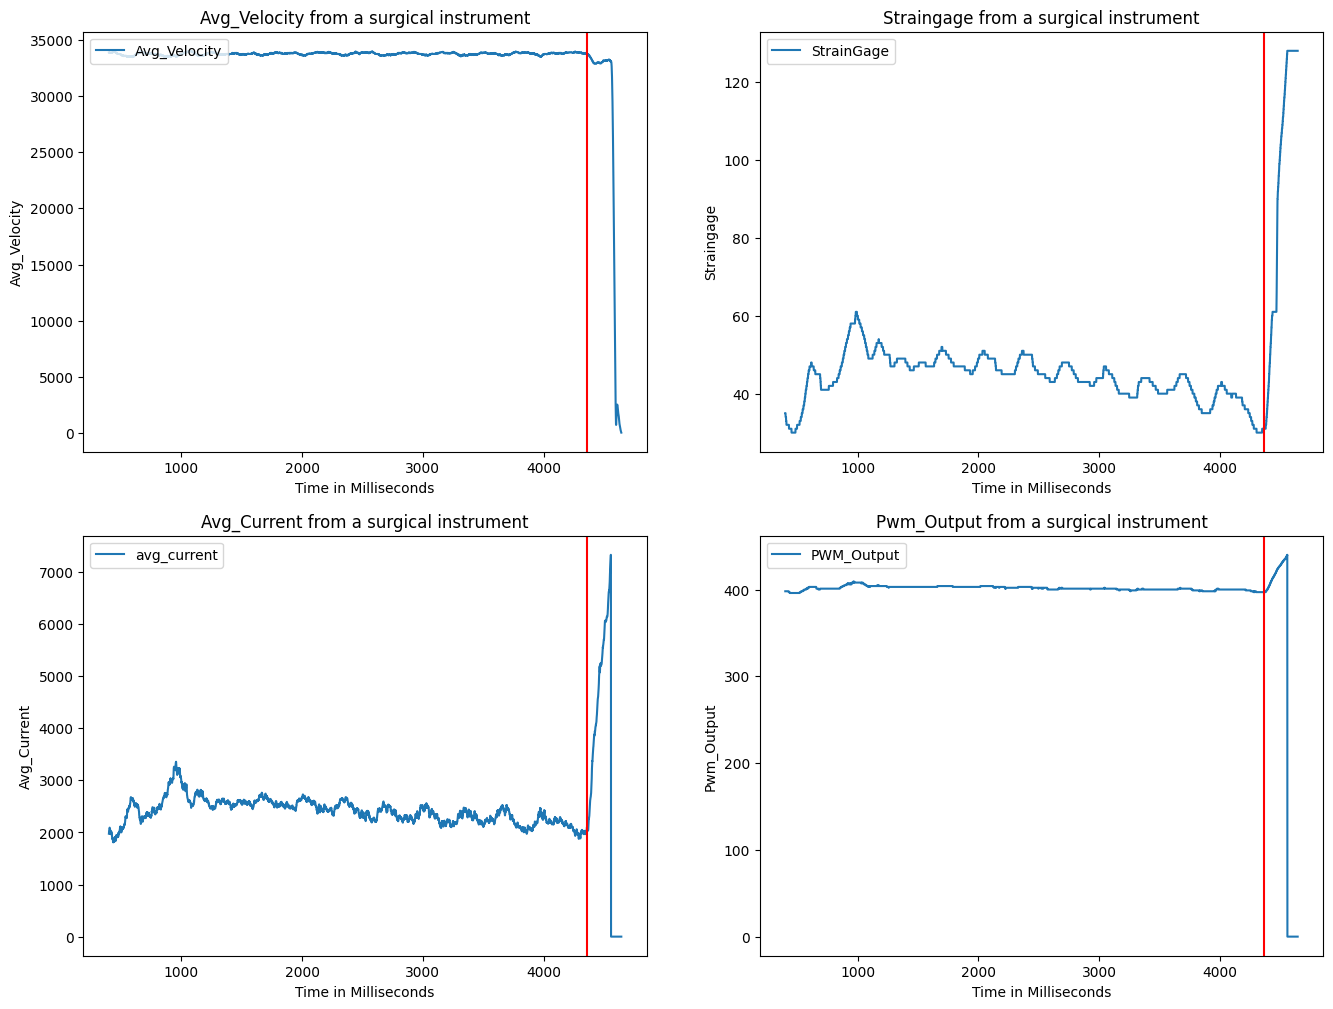

In [100]:
df_97=df["id"]==97
plot_measure(df[df_97])

In [101]:
df[['TimeMS','id']].groupby('id').count()

,TimeMS
id,
2,3764
3,3681
4,7436
5,7468
6,7376
...,...
366,12422
368,22102
370,12286


In [102]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming your DataFrame is named 'df'
# ... (previous code to define 'df' and other steps)

# Step 6: Pad sequences to ensure each 'id' has the same length as the maximum sequence length
max_seq_length = df[['TimeMS', 'id']].groupby('id').count().max().values[0]

# Create a dictionary to store sequences for each 'id' group
id_sequences = {}

# Group data by 'id' and store sequences in the dictionary
for id_group in df.groupby('id'):
    id_value, group_df = id_group
    sequence = group_df['TimeMS'].values
    id_sequences[id_value] = sequence

# Pad each sequence individually using the pad_sequences function for 'TimeMS'
padded_sequences = [pad_sequences([sequence], maxlen=max_seq_length, padding='pre', value=0)[0] for sequence in id_sequences.values()]

# Initialize a dictionary to store the padded sequences for each column
padded_data_dict = {}

# Pad each sequence individually using the pad_sequences function for other columns
for col in df.columns:
    if col not in ['TimeMS', 'id']:
        sequences = [group_df[col].values for _, group_df in df.groupby('id')]
        padded_sequences_col = [pad_sequences([sequence], maxlen=max_seq_length, padding='pre', value=0)[0] for sequence in sequences]
        padded_data_dict[col] = np.concatenate(padded_sequences_col, axis=0)

# Add 'Padded_TimeMS' column to the dictionary
padded_data_dict['Padded_TimeMS'] = np.concatenate(padded_sequences, axis=0)

# Add 'id' column to the dictionary
padded_data_dict['id'] = np.repeat(df['id'].unique(), max_seq_length)

# Create the final DataFrame with padded sequences for all columns
padded_df = pd.DataFrame(data=padded_data_dict)

# Now, 'padded_df' contains the data with padded sequences, and each 'id' has the same length as the maximum sequence length


In [103]:
padded_df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,Padded_TimeMS,id
0,0,0,0,0,0,0,100
1,0,0,0,0,0,0,100
2,0,0,0,0,0,0,100
3,0,0,0,0,0,0,100
4,0,0,0,0,0,0,100
...,...,...,...,...,...,...,...
10991995,93,163,0,0,10522,11049,97
10991996,62,163,0,0,10522,11050,97
10991997,62,163,0,0,10522,11050,97
10991998,31,163,0,0,10522,11051,97


In [104]:
padded_df[['Padded_TimeMS','id']].groupby('id').count()



,Padded_TimeMS
id,
2,43968
3,43968
4,43968
5,43968
6,43968
...,...
366,43968
368,43968
370,43968


In [105]:
import pandas as pd

# Assuming your dataset is already loaded into the DataFrame called "padded_df"
# If not, you can load it from your data source using pd.read_csv or any other method.

# Add a new column "Label" and initialize it with 0
padded_df['Label'] = 0

# Update "Label" to 1 for rows where "Padded_TimeMS" is greater than "Anomaly_At_Time_ms"
padded_df.loc[padded_df['Padded_TimeMS'] > padded_df['Anomaly_At_Time_ms'], 'Label'] = 1




In [106]:
padded_df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,Padded_TimeMS,id,Label
0,0,0,0,0,0,0,100,0
1,0,0,0,0,0,0,100,0
2,0,0,0,0,0,0,100,0
3,0,0,0,0,0,0,100,0
4,0,0,0,0,0,0,100,0
...,...,...,...,...,...,...,...,...
10991995,93,163,0,0,10522,11049,97,1
10991996,62,163,0,0,10522,11050,97,1
10991997,62,163,0,0,10522,11050,97,1
10991998,31,163,0,0,10522,11051,97,1


In [107]:
#padded_df.to_csv("padded.csv", index=False)

In [108]:
features = padded_df[['Avg_Velocity','StrainGage','avg_current','PWM_Output']]
label = padded_df['Label']

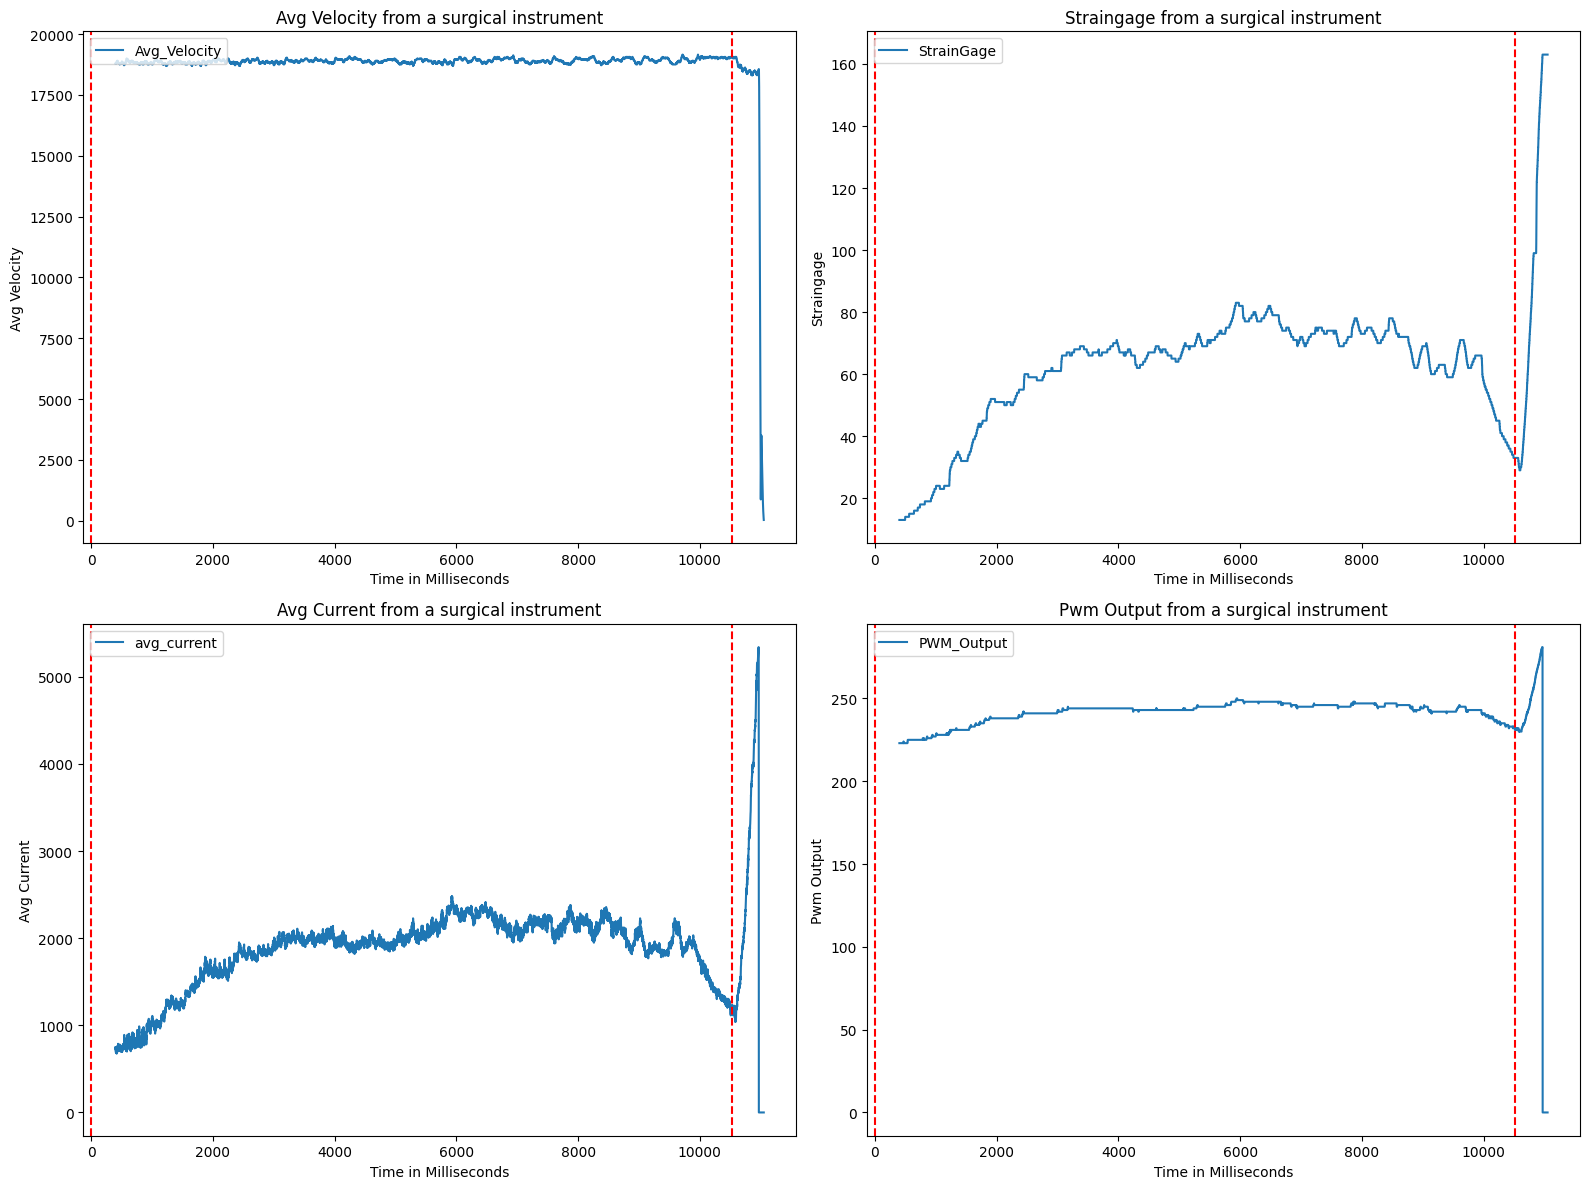

In [109]:
import numpy as np
import matplotlib.pyplot as plt

def plot_measure(padded_df):
    unique_times = np.unique(padded_df['Anomaly_At_Time_ms'])
    df = padded_df[padded_df['Padded_TimeMS'] > 400]

    plt.figure(figsize=(16, 12))

    for i, measure in enumerate(['Avg_Velocity', 'StrainGage', 'avg_current', 'PWM_Output']):
        plt.subplot(2, 2, i+1)
        plt.title(measure.replace('_', ' ').title() + ' from a surgical instrument')
        plt.xlabel('Time in Milliseconds')
        plt.ylabel(measure.replace('_', ' ').title())
        plt.plot('Padded_TimeMS', measure, data=df)

        # Add vertical lines for each unique Anomaly_At_Time_ms value
        for t in unique_times:
            plt.axvline(t, color='r', linestyle='--')

        plt.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

# Assuming you have the 'padded_df' DataFrame
padded_df_97 = padded_df[padded_df["id"] == 97]
plot_measure(padded_df_97)


In [110]:
padded_df

,Avg_Velocity,StrainGage,avg_current,PWM_Output,Anomaly_At_Time_ms,Padded_TimeMS,id,Label
0,0,0,0,0,0,0,100,0
1,0,0,0,0,0,0,100,0
2,0,0,0,0,0,0,100,0
3,0,0,0,0,0,0,100,0
4,0,0,0,0,0,0,100,0
...,...,...,...,...,...,...,...,...
10991995,93,163,0,0,10522,11049,97,1
10991996,62,163,0,0,10522,11050,97,1
10991997,62,163,0,0,10522,11050,97,1
10991998,31,163,0,0,10522,11051,97,1


In [111]:
import numpy as np

# Separate features and labels for training and testing sets
#X = padded_df.drop(['Label', 'id', 'Anomaly_At_Time_ms', 'Padded_TimeMS'], axis=1)
X = padded_df[['avg_current']]
Y = padded_df[['Label']]

# Convert data to numpy arrays
X_np = X.values
Y_np = Y.values.ravel()

# Separate normal and faulty samples
X_normal = X_np[Y_np == 0]
X_faulty = X_np[Y_np == 1]
Y_normal = Y_np[Y_np == 0]
Y_faulty = Y_np[Y_np == 1]

In [112]:
# Determine the index to split between training and testing data
split_index = int(0.8 * len(X_normal))  # 80% for training, 20% for testing

# Split the data into training and testing sets
X_train = X_normal[:split_index]
X_test_1 = X_normal[split_index:]
Y_train = Y_normal[:split_index]
Y_test_1 = Y_normal[split_index:]

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test_1.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test_1.shape)


Shape of X_train: (8680403, 1)
Shape of X_test: (2170101, 1)
Shape of Y_train: (8680403,)
Shape of Y_test: (2170101,)


In [113]:
# Combine X_test_1 and X_faulty to create a new combined test set
X_test= np.concatenate((X_test_1, X_faulty), axis=0)

# Create corresponding labels for the combined test set
Y_test = np.concatenate((np.zeros(len(X_test_1)), np.ones(len(X_faulty))), axis=0)

print("Shape of X_test_combined:", X_test.shape)
print("Shape of Y_test_combined:", Y_test.shape)


Shape of X_test_combined: (2311597, 1)
Shape of Y_test_combined: (2311597,)


In [114]:
print(X_train.shape)
print(X_test.shape)

(8680403, 1)
(2311597, 1)


In [115]:
from sklearn.preprocessing import StandardScaler
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [116]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(8680403, 1)
(2311597, 1)


In [117]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_inputs = 1024
n_features = 1
# Create generator for target data (Y_normal)
#target_generator_test = TimeseriesGenerator(Y_faulty, Y_faulty, length=n_inputs, batch_size=1024)

generator_train = TimeseriesGenerator(X_train_scaled, Y_train, length=n_inputs, batch_size=1024)

for i in range(len(generator_train)):
    x_normal, y_normal= generator_train[i]
    print(f'\n {x_normal.flatten()} and {y_normal}')

Streaming output truncated to the last 5000 lines.
  1.90901406] and [0 0 0 ... 0 0 0]

 [-0.48199259 -0.48199259 -0.48199259 ...  2.43670067  2.50471361
  2.51878525] and [0 0 0 ... 0 0 0]

 [1.91253197 1.91370461 1.93481207 ... 2.83187931 2.82367085 2.83539722] and [0 0 0 ... 0 0 0]

 [2.53754744 2.56451809 2.568036   ... 3.11096689 3.07813306 3.08047833] and [0 0 0 ... 0 0 0]

 [2.83070667 2.82484348 2.8506415  ... 2.8506415  2.84712358 2.85884995] and [0 0 0 ... 0 0 0]

 [ 3.08634151  3.07461514  3.06757932 ... -0.48199259 -0.48199259
 -0.48199259] and [0 0 0 ... 0 0 0]

 [ 2.85533204  2.88699324  2.87878478 ... -0.48199259 -0.48199259
 -0.48199259] and [0 0 0 ... 0 0 0]

 [-0.48199259 -0.48199259 -0.48199259 ... -0.48199259 -0.48199259
 -0.48199259] and [0 0 0 ... 0 0 0]

 [-0.48199259 -0.48199259 -0.48199259 ... -0.48199259 -0.48199259
 -0.48199259] and [0 0 0 ... 0 0 0]

 [-0.48199259 -0.48199259 -0.48199259 ... -0.48199259 -0.48199259
 -0.48199259] and [0 0 0 ... 0 0 0]

 [-0.4

In [118]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_inputs = 1024
n_features = 1
# Create generator for target data (Y_normal)
#target_generator_test = TimeseriesGenerator(Y_faulty, Y_faulty, length=n_inputs, batch_size=1024)

generator_test = TimeseriesGenerator(X_test_scaled, Y_test, length=n_inputs, batch_size=1024)

for i in range(len(generator_test)):
    x_faulty, y_faulty= generator_test[i]
    print(f'\n {x_faulty.flatten()} and {y_faulty}')

Streaming output truncated to the last 5000 lines.
 -0.48199259] and [0. 0. 0. ... 0. 0. 0.]

 [-0.48199259 -0.48199259 -0.48199259 ... -0.48199259 -0.48199259
 -0.48199259] and [0. 0. 0. ... 0. 0. 0.]

 [-0.48199259 -0.48199259 -0.48199259 ... -0.48199259 -0.48199259
 -0.48199259] and [0. 0. 0. ... 0. 0. 0.]

 [-0.48199259 -0.48199259 -0.48199259 ... -0.48199259 -0.48199259
 -0.48199259] and [0. 0. 0. ... 0. 0. 0.]

 [-0.48199259 -0.48199259 -0.48199259 ... -0.48199259 -0.48199259
 -0.48199259] and [0. 0. 0. ... 0. 0. 0.]

 [-0.48199259 -0.48199259 -0.48199259 ... -0.48199259 -0.48199259
 -0.48199259] and [0. 0. 0. ... 0. 0. 0.]

 [-0.48199259 -0.48199259 -0.48199259 ... -0.48199259 -0.48199259
 -0.48199259] and [0. 0. 0. ... 0. 0. 0.]

 [-0.48199259 -0.48199259 -0.48199259 ... -0.48199259 -0.48199259
 -0.48199259] and [0. 0. 0. ... 0. 0. 0.]

 [-0.48199259 -0.48199259 -0.48199259 ... -0.48199259 -0.48199259
 -0.48199259] and [0. 0. 0. ... 0. 0. 0.]

 [-0.48199259 -0.48199259 -0.48199

In [119]:
Y_test

array([0., 0., 0., ..., 1., 1., 1.])

In [120]:
y_faulty

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [121]:
x_normal.shape

(979, 1024, 1)

In [122]:
#Flattening the x
x_normal_r = x_normal.reshape((x_normal.shape[0], -1))
x_faulty_r = x_faulty.reshape((x_faulty.shape[0], -1))

In [123]:
x_normal_r.shape

(979, 1024)

In [124]:
import numpy as np

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [125]:
x_normal_r.shape

(979, 1024)

In [126]:
original_dim = x_normal_r.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 4)
latent_dim = int(original_dim / 32)

In [127]:
# The reparameterization trick
from tensorflow.math import reduce_prod

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [128]:
from tensorflow.keras import regularizers
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
z_mean = Dense(latent_dim, name='z_mean', kernel_regularizer=regularizers.l2(0.01))(x)
z_log_var = Dense(latent_dim, name='z_log_var', kernel_regularizer=regularizers.l2(0.01))(x)

# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 1024)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          262400      ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 32)           8224        ['dense_3[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 32)           8224        ['dense_3[0][0]']                
                                                                                            

In [129]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)

# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 32)]              0         
                                                                 
 dense_4 (Dense)             (None, 256)               8448      
                                                                 
 dense_5 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 271,616
Trainable params: 271,616
Non-trainable params: 0
_________________________________________________________________


In [130]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [131]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all
    total_loss = K.mean(reconstruction_loss + kl_loss)
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [132]:
from tensorflow.keras import optimizers
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
#x_normal = x_normal.reshape(-1, original_dim) # Assuming 200 is the desired input shape (n_inputs * n_features)

results = vae_model.fit(x_normal_r, x_normal_r,
                        shuffle=True,
                        epochs=300,
                        batch_size=516)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 1024)]            0         
                                                                 
 encoder (Functional)        (None, 32)                278848    
                                                                 
 decoder (Functional)        (None, 1024)              271616    
                                                                 
Total params: 550,464
Trainable params: 550,464
Non-trainable params: 0
_________________________________________________________________
Train on 979 samples
Epoch 1/300
979/979 [==============================] - 0s 340us/sample - loss: 223547.3304
Epoch 2/300
979/979 [==============================] - 0s 90us/sample - loss: 218703.5289
Epoch 3/300
979/979 [==============================] - 0s 80us/sample - loss: 214200.1000
Epoch 4/300
979/979 [====

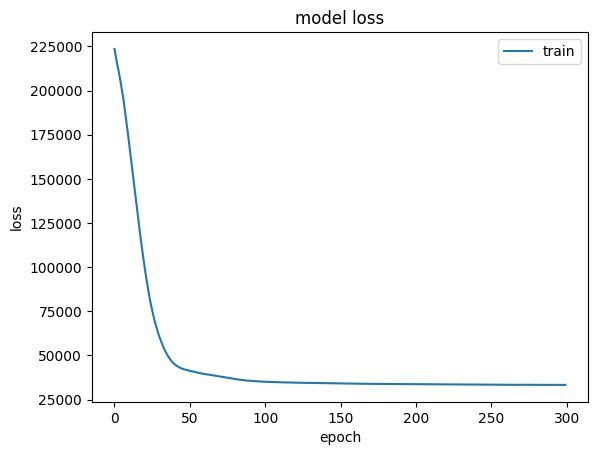

In [133]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [134]:
import os
# Save the plot as an EPS file
plt.savefig('VAE_train.eps', format='eps', bbox_inches='tight')
# Get the full path of the saved file
full_path = os.path.abspath("VAE_train.eps")
print(f"EPS file saved at: {full_path}")
# Display the plot
plt.show()

EPS file saved at: /content/VAE_train.eps


<Figure size 640x480 with 0 Axes>

In [135]:
X_normal_pred = vae_model.predict(x_normal_r)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [136]:
X_normal_pred.shape

(979, 1024)

In [137]:
mae_vector = get_error_term(X_normal_pred, x_normal_r, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.188877335309987
median error 0.18822885583443613
99Q: 0.2624735613969395
setting threshold on 0.2624735613969395 


In [138]:
mae_vector


array([0.08079368, 0.08309485, 0.0778155 , 0.076106  , 0.07951853,
       0.07979962, 0.07764392, 0.08007877, 0.08000616, 0.07803241,
       0.0837119 , 0.07837037, 0.0809129 , 0.07977089, 0.07866148,
       0.08015065, 0.08027707, 0.08355214, 0.08420706, 0.0830671 ,
       0.08118942, 0.08375126, 0.08301581, 0.08234769, 0.08502661,
       0.08414462, 0.08310179, 0.08260089, 0.0838546 , 0.08546377,
       0.08516064, 0.08758234, 0.08497212, 0.088663  , 0.0860743 ,
       0.08760501, 0.086358  , 0.08597022, 0.08662583, 0.08761699,
       0.08745155, 0.08853191, 0.08925191, 0.08902289, 0.08944967,
       0.09014851, 0.0906587 , 0.0918254 , 0.09233405, 0.09251959,
       0.09215472, 0.09318738, 0.0928077 , 0.09350212, 0.09390177,
       0.09400195, 0.0947907 , 0.09503032, 0.09527804, 0.09604331,
       0.09595154, 0.09782746, 0.09706473, 0.09767104, 0.09736576,
       0.0978668 , 0.09855816, 0.09793521, 0.09917802, 0.09965742,
       0.10053844, 0.10296072, 0.10020076, 0.10048084, 0.10048

In [139]:
X_pred = vae_model.predict(x_faulty_r)
mae_vector = get_error_term(X_pred, x_faulty_r, _rmse=False)
# Set a threshold for anomaly detection
threshold = np.percentile(mae_vector, 50)
print(threshold)
anomalies = (mae_vector > threshold)

np.count_nonzero(anomalies) / len(anomalies)

1.6075343446981


0.4988344988344988

In [140]:
anomalies

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [141]:
from sklearn.metrics import classification_report
print(classification_report(y_faulty, anomalies))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67       429

    accuracy                           0.50       429
   macro avg       0.50      0.25      0.33       429
weighted avg       1.00      0.50      0.67       429



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [142]:
mae_vector

array([1.11103673, 1.11129217, 1.11292066, 1.11449041, 1.11673051,
       1.11894916, 1.11985723, 1.12110281, 1.12360108, 1.12520033,
       1.12605857, 1.12863999, 1.13057622, 1.13227063, 1.13478671,
       1.13744207, 1.13925651, 1.14171155, 1.14381969, 1.14638178,
       1.15066479, 1.15371088, 1.15716493, 1.16022109, 1.16224468,
       1.16597989, 1.17075645, 1.17149814, 1.17592057, 1.18084672,
       1.18464799, 1.18737714, 1.19003474, 1.19380645, 1.19711586,
       1.19977711, 1.1976474 , 1.20236662, 1.20672248, 1.21096432,
       1.21645138, 1.21749127, 1.22135065, 1.22138602, 1.22650319,
       1.22898218, 1.23286216, 1.23365843, 1.23730453, 1.2428669 ,
       1.24844118, 1.25026167, 1.25154395, 1.2578513 , 1.26172757,
       1.26429796, 1.26572218, 1.26668092, 1.27218204, 1.27555729,
       1.27780166, 1.28082266, 1.28548484, 1.29190172, 1.29600769,
       1.30036164, 1.30340893, 1.30701322, 1.30803933, 1.31062323,
       1.31527421, 1.31568636, 1.31944726, 1.32333922, 1.32468

In [143]:
error_thresh=1.2
X_pred = vae_model.predict(x_faulty_r)
mae_vector = get_error_term(X_pred, x_faulty_r, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.9137529137529138

In [144]:
anomalies.shape

(429,)

In [145]:
from sklearn.metrics import classification_report
print(classification_report(y_faulty, anomalies))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.91      0.95       429

    accuracy                           0.91       429
   macro avg       0.50      0.46      0.48       429
weighted avg       1.00      0.91      0.95       429



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


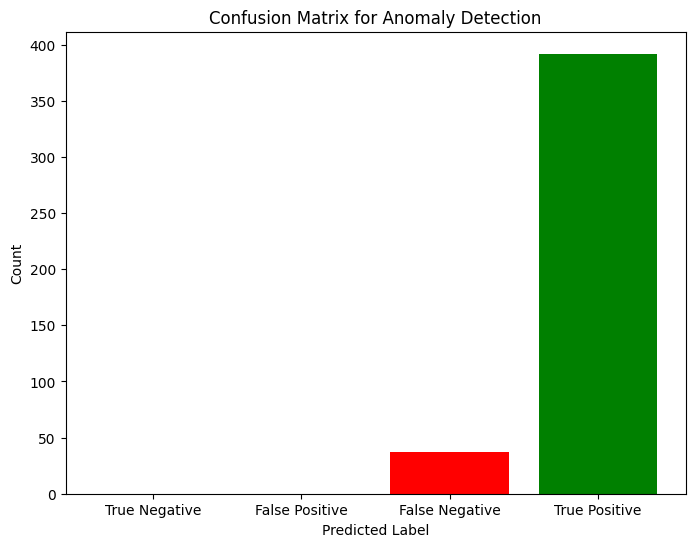

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Given error threshold
error_thresh = 1.2

# Calculate anomalies based on the threshold
X_pred = vae_model.predict(x_faulty_r)
mae_vector = get_error_term(X_pred, x_faulty_r, _rmse=False)
anomalies = (mae_vector > error_thresh).astype(int)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_faulty, anomalies)

# Extract values from the confusion matrix
true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()

# Plot the bar chart
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
values = [true_negative, false_positive, false_negative, true_positive]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['green', 'red', 'red', 'green'])
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Confusion Matrix for Anomaly Detection')
plt.show()


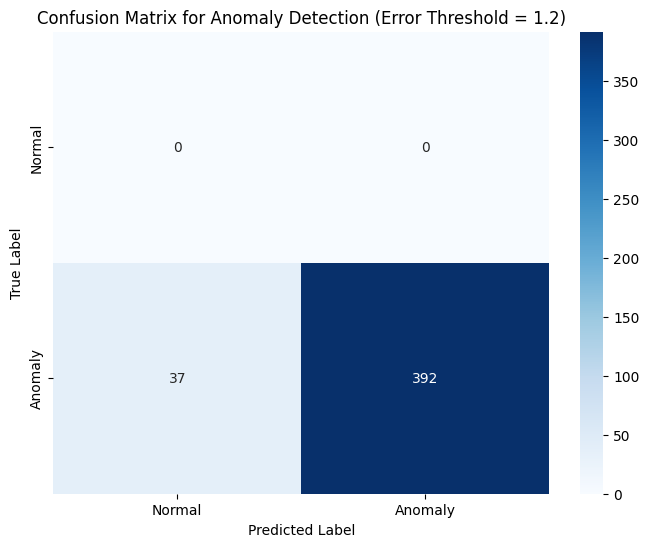

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Given error threshold
error_thresh = 1.2

# Calculate anomalies based on the threshold
X_pred = vae_model.predict(x_faulty_r)
mae_vector = get_error_term(X_pred, x_faulty_r, _rmse=False)
anomalies = (mae_vector > error_thresh).astype(int)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_faulty, anomalies)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for Anomaly Detection (Error Threshold = {error_thresh})')
plt.show()


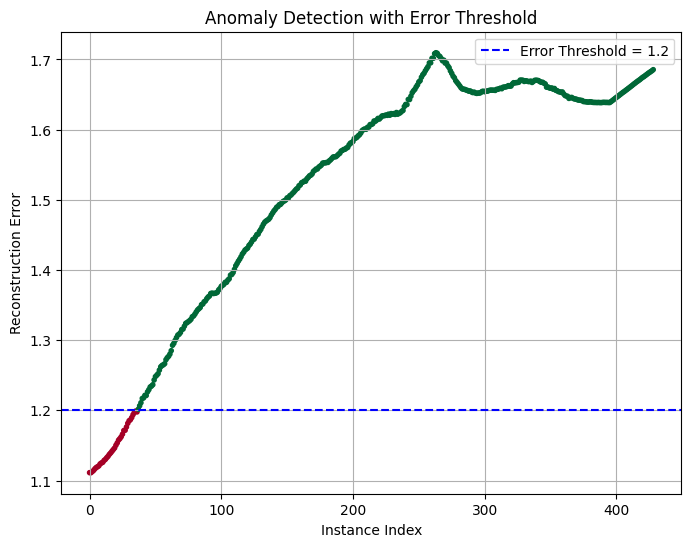

In [148]:
import numpy as np
import matplotlib.pyplot as plt

# Given error threshold
error_thresh = 1.2

# Calculate anomalies based on the threshold
X_pred = vae_model.predict(x_faulty_r)
mae_vector = get_error_term(X_pred, x_faulty_r, _rmse=False)
anomalies = (mae_vector > error_thresh)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(anomalies)), mae_vector, c=anomalies, cmap='RdYlGn', marker='.')
plt.axhline(y=error_thresh, color='b', linestyle='--', label=f'Error Threshold = {error_thresh}')
plt.xlabel('Instance Index')
plt.ylabel('Reconstruction Error')
plt.title('Anomaly Detection with Error Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [155]:
# Save the plot as an EPS file
plt.savefig('Anomaly Detection with Error Threshold.eps', format='eps')

<Figure size 640x480 with 0 Axes>

In [149]:
error_thresh=1.4
X_pred = vae_model.predict(x_faulty_r)
mae_vector = get_error_term(X_pred, x_faulty_r, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)


0.7435897435897436

In [150]:
from sklearn.metrics import classification_report
print(classification_report(y_faulty, anomalies))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.74      0.85       429

    accuracy                           0.74       429
   macro avg       0.50      0.37      0.43       429
weighted avg       1.00      0.74      0.85       429



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
